In [1]:
#meta 5/31/2022 SARIMAX: Introduction ($note: together with .pdf)
#This notebook replicates examples from the Stata ARIMA time series estimation and postestimation documentation.
#refer to src https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

#original doc @ references_original/Stata
#refer to http://www.stata.com/manuals13/tsarima.pdf or https://www.stata.com/features/time-series/ts-arima.pdf


#history
# 5/31/2022 Statsmodels documentation
#      Replicated nb, goes together with documenation .pdf


#References: a good place to start
#refer to https://www.statsmodels.org/dev/examples/index.html 


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import requests
from io import BytesIO
%matplotlib inline
import matplotlib.pyplot as plt
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

#from scipy.stats import norm
import statsmodels.api as sm


# SARIMAX: Introduction
This notebook replicates examples from the Stata ARIMA time series estimation and postestimation documentation.  
$note: together with .pdf


## 1. First, we replicate the four estimation examples
http://www.stata.com/manuals13/tsarima.pdf

1. `ARIMA(1,1,1)` model on the U.S. Wholesale Price Index (WPI) dataset.

2. Variation of example 1 which adds an `MA(4)` term to the `ARIMA(1,1,1)` specification to allow for an additive seasonal effect.

3. `ARIMA(2,1,0) x (1,1,0,12)` model of monthly airline data. This example allows a multiplicative seasonal effect.

4. `ARMA(1,1)` model with exogenous regressors; describes consumption as an autoregressive process on which also the money supply is assumed to be an explanatory variable.

## 2. Second, we demonstrate postestimation capabilities 
to replicate http://www.stata.com/manuals13/tsarimapostestimation.pdf. The model from example 4 is used to demonstrate:

1. One-step-ahead in-sample prediction

2. n-step-ahead out-of-sample forecasting

3. n-step-ahead in-sample dynamic prediction


## 1. ARIMA Estimation
### Example 1: Arima

In [3]:
#0. Load data
# Dataset: Wholesale price index (WPI)
wpi1 = requests.get('https://www.stata-press.com/data/r12/wpi1.dta').content

#1. Prep data
data = pd.read_stata(BytesIO(wpi1)) #class pandas.core.frame.DataFrame
data.index = data.t
# Set the frequency
data.index.freq="QS-OCT"

#preview
print(data.shape)
print(data.dtypes)
data.head()

(124, 3)
wpi              float32
t         datetime64[ns]
ln_wpi           float32
dtype: object


,wpi,t,ln_wpi
t,,,
1960-01-01,30.700001,1960-01-01,3.424263
1960-04-01,30.799999,1960-04-01,3.427515
1960-07-01,30.700001,1960-07-01,3.424263
1960-10-01,30.700001,1960-10-01,3.424263
1961-01-01,30.799999,1961-01-01,3.427515


In [4]:
#2. Fit the model
mod = sm.tsa.statespace.SARIMAX(data['wpi'], trend='c', order=(1,1,1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                    wpi   No. Observations:                  124
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -135.351
Date:                Tue, 31 May 2022   AIC                            278.703
Time:                        16:50:07   BIC                            289.951
Sample:                    01-01-1960   HQIC                           283.272
                         - 10-01-1990                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0943      0.068      1.389      0.165      -0.039       0.227
ar.L1          0.8742      0.055     16.028      0.000       0.767       0.981
ma.L1         -0.4120      0.100     -4.119      0.0

### Example 2: Arima with additive seasonal effects

In [5]:
#1. Prep data
#data['ln_wpi'] = np.log(data['wpi'])
data['D.ln_wpi'] = data['ln_wpi'].diff()

#preview
print(data.shape)
print(data.dtypes)
data.head()

(124, 4)
wpi                float32
t           datetime64[ns]
ln_wpi             float32
D.ln_wpi           float32
dtype: object


,wpi,t,ln_wpi,D.ln_wpi
t,,,,
1960-01-01,30.700001,1960-01-01,3.424263,NaN
1960-04-01,30.799999,1960-04-01,3.427515,0.003252
1960-07-01,30.700001,1960-07-01,3.424263,-0.003252
1960-10-01,30.700001,1960-10-01,3.424263,0.000000
1961-01-01,30.799999,1961-01-01,3.427515,0.003252


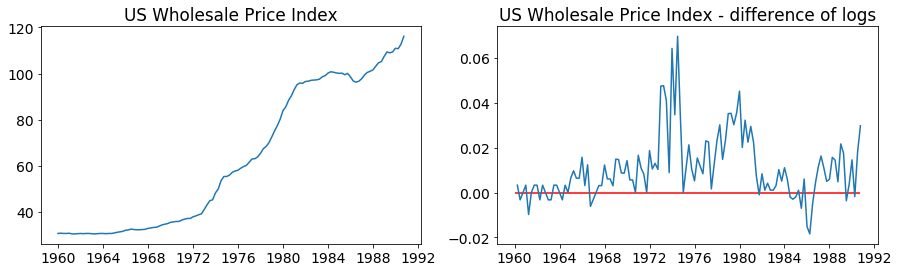

In [6]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# Levels
axes[0].plot(data.index._mpl_repr(), data['wpi'], '-')
axes[0].set(title='US Wholesale Price Index')

# Log difference
axes[1].plot(data.index._mpl_repr(), data['D.ln_wpi'], '-')
axes[1].hlines(0, data.index[0], data.index[-1], 'r')
axes[1].set(title='US Wholesale Price Index - difference of logs');

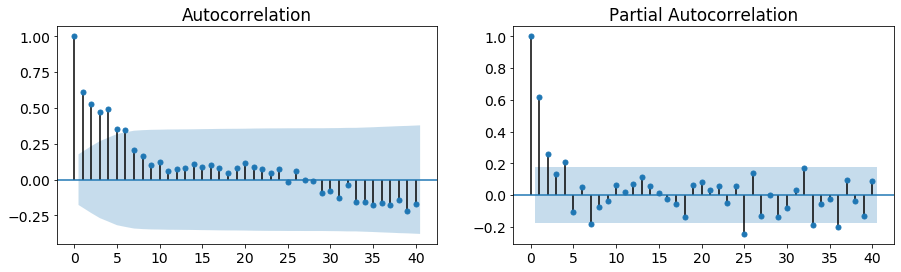

In [7]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(data.iloc[1:]['D.ln_wpi'], lags=40, ax=axes[1])

In [8]:
#2. Fit the model
mod = sm.tsa.statespace.SARIMAX(data['ln_wpi'], trend='c', order=(1,1,(1,0,0,1)))
res = mod.fit(disp=False)
print(res.summary())

                                 SARIMAX Results                                 
Dep. Variable:                    ln_wpi   No. Observations:                  124
Model:             SARIMAX(1, 1, [1, 4])   Log Likelihood                 386.033
Date:                   Tue, 31 May 2022   AIC                           -762.067
Time:                           16:50:09   BIC                           -748.006
Sample:                       01-01-1960   HQIC                          -756.355
                            - 10-01-1990                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0024      0.002      1.481      0.139      -0.001       0.006
ar.L1          0.7816      0.094      8.280      0.000       0.597       0.967
ma.L1         -0.4003      0

### Example 3: Airline Model

In [9]:
#0. Load data
#Dataset
air2 = requests.get('https://www.stata-press.com/data/r12/air2.dta').content

#1. Prep data
data = pd.read_stata(BytesIO(air2))
data.index = pd.date_range(start=datetime(data.time[0], 1, 1), periods=len(data), freq='MS')
data['ln_air'] = np.log(data['air'])

#preview
print(data.shape)
print(data.dtypes)
data.head()

(144, 4)
air         int16
time      float32
t         float32
ln_air    float32
dtype: object


,air,time,t,ln_air
1949-01-01,112,1949.000000,1.0,4.718499
1949-02-01,118,1949.083374,2.0,4.770685
1949-03-01,132,1949.166626,3.0,4.882802
1949-04-01,129,1949.250000,4.0,4.859812
1949-05-01,121,1949.333374,5.0,4.795791


In [10]:
#2. Fit the model
mod = sm.tsa.statespace.SARIMAX(data['ln_air'], order=(2,1,0), seasonal_order=(1,1,0,12), simple_differencing=True)
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      D.DS12.ln_air   No. Observations:                  131
Model:             SARIMAX(2, 0, 0)x(1, 0, 0, 12)   Log Likelihood                 240.821
Date:                            Tue, 31 May 2022   AIC                           -473.643
Time:                                    16:50:10   BIC                           -462.142
Sample:                                02-01-1950   HQIC                          -468.970
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4057      0.080     -5.045      0.000      -0.563      -0.248
ar.L2         -0.0799      0.099   

### Example 4: ARMAX (Friedman)

In [11]:
#0. Load data
# Dataset
friedman2 = requests.get('https://www.stata-press.com/data/r12/friedman2.dta').content

#1. Prep data
data = pd.read_stata(BytesIO(friedman2))
data.index = data.time
data.index.freq = "QS-OCT"

# Variables
endog = data.loc['1959':'1981', 'consump']
exog = sm.add_constant(data.loc['1959':'1981', 'm2'])

#preview
print(data.shape)
print(data.dtypes)
data.head()

(211, 5)
m2                float32
time       datetime64[ns]
m1                float32
consump           float32
pc92              float32
dtype: object


,m2,time,m1,consump,pc92
time,,,,,
1946-01-01,NaN,1946-01-01,NaN,134.899994,NaN
1946-04-01,NaN,1946-04-01,NaN,140.100006,NaN
1946-07-01,NaN,1946-07-01,NaN,148.899994,NaN
1946-10-01,NaN,1946-10-01,NaN,153.199997,NaN
1947-01-01,NaN,1947-01-01,NaN,156.600006,912.099976


In [12]:
#2. Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                   92
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -340.508
Date:                Tue, 31 May 2022   AIC                            691.015
Time:                        16:50:11   BIC                            703.624
Sample:                    01-01-1959   HQIC                           696.105
                         - 10-01-1981                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.0429     56.698     -0.636      0.525    -147.168      75.082
m2             1.1220      0.036     30.801      0.000       1.051       1.193
ar.L1          0.9349      0.041     22.716      0.0

## 2. ARIMA Postestimation
### Example 1 - Dynamic Forecasting

In [13]:
#1. Prep data
raw = pd.read_stata(BytesIO(friedman2))
raw.index = raw.time
raw.index.freq = "QS-OCT"
data = raw.loc[:'1981']

# Variables
endog = data.loc['1959':, 'consump']
exog = sm.add_constant(data.loc['1959':, 'm2'])
nobs = endog.shape[0]

#preview
print(data.shape)
print(data.dtypes)
data.head()

(144, 5)
m2                float32
time       datetime64[ns]
m1                float32
consump           float32
pc92              float32
dtype: object


,m2,time,m1,consump,pc92
time,,,,,
1946-01-01,NaN,1946-01-01,NaN,134.899994,NaN
1946-04-01,NaN,1946-04-01,NaN,140.100006,NaN
1946-07-01,NaN,1946-07-01,NaN,148.899994,NaN
1946-10-01,NaN,1946-10-01,NaN,153.199997,NaN
1947-01-01,NaN,1947-01-01,NaN,156.600006,912.099976


In [14]:
#2. Fit the model
mod = sm.tsa.statespace.SARIMAX(endog.loc[:'1978-01-01'], exog=exog.loc[:'1978-01-01'], order=(1,0,1))
fit_res = mod.fit(disp=False, maxiter=250)
print(fit_res.summary())

                               SARIMAX Results                                
Dep. Variable:                consump   No. Observations:                   77
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -243.316
Date:                Tue, 31 May 2022   AIC                            496.633
Time:                        16:50:11   BIC                            508.352
Sample:                    01-01-1959   HQIC                           501.320
                         - 01-01-1978                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6773     18.491      0.037      0.971     -35.564      36.919
m2             1.0379      0.021     50.331      0.000       0.997       1.078
ar.L1          0.8775      0.059     14.859      0.0

##### Post Estimation
Get results for the full dataset but using the estimated parameters (on a subset of the data).

In [15]:
#3. Predict
#get results for the full dataset but using the estimated parameters (on a subset of the data).
mod = sm.tsa.statespace.SARIMAX(endog, exog=exog, order=(1,0,1))
res = mod.filter(fit_res.params)

##### - in-sample predictions
The `predict` command is first applied here to get in-sample predictions. We use the `full_results=True` argument to allow us to calculate confidence intervals (the default output of predict is just the predicted values).

With no other arguments, `predict` returns the one-step-ahead in-sample predictions for the entire sample.

In [16]:
# In-sample one-step-ahead predictions
predict = res.get_prediction()
predict_ci = predict.conf_int()

We can also get dynamic predictions. One-step-ahead prediction uses the true values of the endogenous values at each step to predict the next in-sample value. Dynamic predictions use one-step-ahead prediction up to some point in the dataset (specified by the `dynamic` argument); after that, the previous predicted endogenous values are used in place of the true endogenous values for each new predicted element.

The dynamic argument is specified to be an offset relative to the `start` argument. If `start` is not specified, it is assumed to be `0`.

In [17]:
# Dynamic predictions: starting in the first quarter of 1978
predict_dy = res.get_prediction(dynamic='1978-01-01')
predict_dy_ci = predict_dy.conf_int()

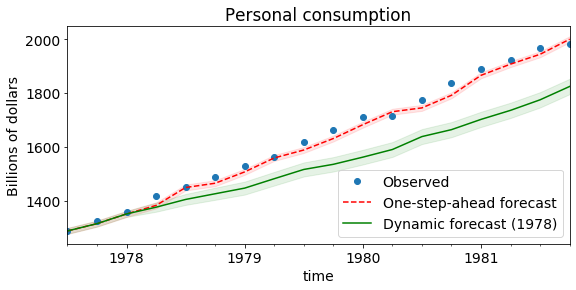

In [18]:
# graph the one-step-ahead and dynamic predictions (and the corresponding confidence intervals) to see their relative performance. 
#Notice that up to the point where dynamic prediction begins (1978:Q1), the two are the same

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Personal consumption', xlabel='Date', ylabel='Billions of dollars')

# Plot data points
data.loc['1977-07-01':, 'consump'].plot(ax=ax, style='o', label='Observed')

# Plot predictions
predict.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='r--', label='One-step-ahead forecast')
ci = predict_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
predict_dy.predicted_mean.loc['1977-07-01':].plot(ax=ax, style='g', label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc['1977-07-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)

legend = ax.legend(loc='lower right')

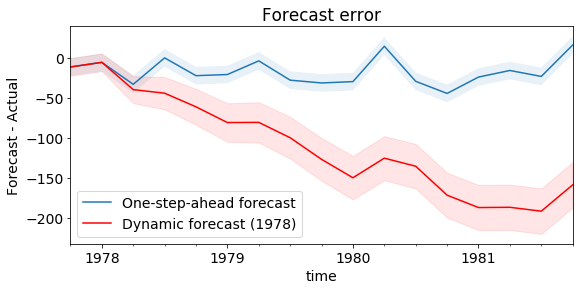

In [19]:
#graph the prediction error
#It is obvious that, as one would suspect, one-step-ahead prediction is considerably better.
# Prediction error

# Graph
fig, ax = plt.subplots(figsize=(9,4))
npre = 4
ax.set(title='Forecast error', xlabel='Date', ylabel='Forecast - Actual')

# In-sample one-step-ahead predictions and 95% confidence intervals
predict_error = predict.predicted_mean - endog
predict_error.loc['1977-10-01':].plot(ax=ax, label='One-step-ahead forecast')
ci = predict_ci.loc['1977-10-01':].copy()
ci.iloc[:,0] -= endog.loc['1977-10-01':]
ci.iloc[:,1] -= endog.loc['1977-10-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.1)

# Dynamic predictions and 95% confidence intervals
predict_dy_error = predict_dy.predicted_mean - endog
predict_dy_error.loc['1977-10-01':].plot(ax=ax, style='r', label='Dynamic forecast (1978)')
ci = predict_dy_ci.loc['1977-10-01':].copy()
ci.iloc[:,0] -= endog.loc['1977-10-01':]
ci.iloc[:,1] -= endog.loc['1977-10-01':]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

legend = ax.legend(loc='lower left');
legend.get_frame().set_facecolor('w')